In [1]:
import sys
import os
import pysam
import vcf
import string
import itertools
import argparse
import numpy as np
from operator import itemgetter
from itertools import groupby
from collections import Counter, defaultdict
sys.path.append("/hive/users/ifiddes/comparativeAnnotator")
from sonLib.bioio import popenCatch, fastaRead, system
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from lib.general_lib import format_ratio
%matplotlib inline
bases = {"A", "T", "G", "C", "a", "t", "g", "c"}
from tools.procOps import *

In [2]:
bam_path = 'E2del70_old_consensus.bam'
vcf_path = "/hive/users/ifiddes/amplicon_analysis_with_new_suns/all_samples_reference_free/index/Notch2NL_SUN_UniqueIndels_ConsensusRef.vcf.gz"

In [3]:
vcf_recs = list(vcf.Reader(open(vcf_path)))

In [4]:
results = defaultdict(list)
for vcf_rec in vcf_recs:
    if vcf_rec.is_indel:
        continue
    pos_str = "{0}:{1}-{1}".format(vcf_rec.CHROM, vcf_rec.POS)
    pos = str(vcf_rec.POS)
    mpileup_rec = call_proc_lines(['samtools', 'mpileup', '-q', '20', '-Q', '20', '-r', pos_str, bam_path])
    mpileup_rec = mpileup_rec[0].split()[:-1]
    pile_up_result = Counter(x.upper() for x in mpileup_rec[4] if x in bases)
    sample_dict = {s.sample: s.gt_bases for s in vcf_rec.samples}
    for s in vcf_rec.samples:
        if len([x for x in sample_dict.itervalues() if x == s.gt_bases]) != 1:
            continue
        c = 1.0 * pile_up_result[s.gt_bases] / len(mpileup_rec[4])
        results[s.sample].append([vcf_rec.POS, c])

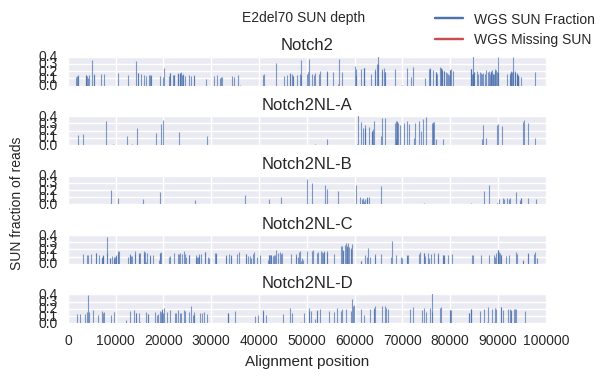

In [18]:
from matplotlib.backends.backend_pdf import PdfPages
with open('E2del70_suns.pdf', 'w') as outf, PdfPages(outf) as pdf:
    paralogs = ['Notch2', 'Notch2NL-A', 'Notch2NL-B', 'Notch2NL-C', 'Notch2NL-D']
    fig, plots = plt.subplots(5, sharey=True, sharex=True)
    plt.yticks((0, 0.1, 0.2, 0.3, 0.4))
    plt.ylim((0, 0.4))
    plt.xticks((0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000))
    plt.xlim((0, 100143))
    plt.xlabel("Alignment position")
    for i, (p, para) in enumerate(zip(plots, paralogs)):
        p.set_title(para)
        wgs = results[para]
        xvals, yvals = zip(*wgs)
        p.vlines(xvals, np.zeros(len(xvals)), yvals, color=sns.color_palette()[0], alpha=0.7, linewidth=0.8)
        # mark the zeros
        zero_wgs = [[x, y + 0.02] for x, y in wgs if y == 0]
        if len(zero_wgs) > 0:
            z_xvals, z_yvals = zip(*zero_wgs)
            p.vlines(z_xvals, np.zeros(len(z_xvals)), z_yvals, color=sns.color_palette()[2], alpha=0.7, linewidth=0.8)
    plt.tight_layout(pad=2.5, h_pad=0.3)
    zero_line = matplotlib.lines.Line2D([], [], color=sns.color_palette()[2])
    reg_line = matplotlib.lines.Line2D([], [], color=sns.color_palette()[0])
    fig.legend(handles=(reg_line, zero_line), labels=["WGS SUN Fraction", "WGS Missing SUN"], loc="upper right")
    fig.text(0.01, 0.5, 'SUN fraction of reads', va='center', rotation='vertical')
    fig.suptitle('E2del70 SUN depth')
    pdf.savefig()